# Loading and inspecting a model

We eventually want to load up the model we trained and use it for stuff. I don't know why this isn't covered more in the docs. Here, we load the graph, the latest set of variables, and then make and write a new graph after "freezing" all of the trained variables to turn them into constants.

## Reading and inspecting it

We load those files and find the input and output entities of the graph. The graph file is kinda just a bag-o-nodes, so we have to give them useful names when we're building the graph originally. We also can't automatically find the inputs... with anything built into tensorflow.

In [1]:
import tensorflow as tf
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
saver = tf.train.import_meta_graph('savemymodel.meta')
saver.restore(sess,'savemymodel')
tf_x =graph.get_tensor_by_name('THEINPUT:0') 
model=graph.get_tensor_by_name('THEMODEL:0')

INFO:tensorflow:Restoring parameters from savemymodel


Verify that it looks right:

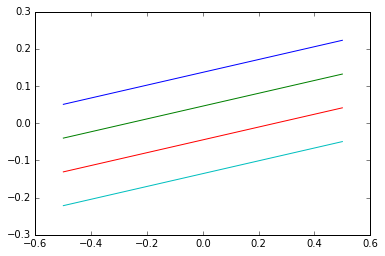

In [2]:
from matplotlib import pylab as plt
import numpy as np
plt.close('all')
for n in np.linspace(-0.5,0.5,4):
    xx = np.zeros((100,2))
    strip = np.linspace(-0.5,0.5,100)
    xx[:,0] = strip
    xx[:,1] = n
    yy = model.eval(feed_dict={tf_x: xx}, session=sess)
    plt.plot(strip,yy,'-')
plt.show()

Lets walk the TensorFlow operation tree and see what it looks like:

In [3]:
from afqstensorutils import *
travel_op((model.op))

THEMODEL  :  Add
    MatMul  :  MatMul
        THEINPUT  :  Placeholder
        Reshape  :  Reshape
            strided_slice  :  StridedSlice
                Variable/read  :  Identity
                    Variable  :  VariableV2
                strided_slice/stack  :  Const
                strided_slice/stack_2  :  Pack
                    strided_slice/stack_2/values_0  :  Const
                strided_slice/stack_3  :  Const
            Reshape/shape  :  Const
    strided_slice_1  :  StridedSlice
        Variable/read  :  Identity
            Variable  :  VariableV2
        strided_slice_1/stack  :  Const
        strided_slice_1/stack_1  :  Const
        strided_slice_1/stack_2  :  Const


## Freezing the model

What we loaded was the graph that was being operated on during optimization. We're done optimizing (for now), so we want to trim down the graph into something that's faster to evaluate and load. This library routine almost does the trick: 

In [4]:
output_graph_def = \
tf.graph_util.convert_variables_to_constants(sess,graph.as_graph_def(),["THEMODEL"])

INFO:tensorflow:Froze 1 variables.
Converted 1 variables to const ops.


But now we need to turn this graph_def object into a graph, and fetch the nodes

In [5]:
a,b=tf.import_graph_def(output_graph_def,return_elements=['THEINPUT:0','THEMODEL:0'])

In [6]:
a

<tf.Tensor 'import/THEINPUT:0' shape=(?, 2) dtype=float32>

Can we evaluate it?

In [7]:
b.eval(feed_dict={a:np.array([[1.0,2.0]])},session=sess)

array([[-0.37182826]], dtype=float32)

Lets travel the op and see how it compares to what we loaded. It looks exactly the same, but with all the variables replaced by constants. 

In [8]:
travel_op(b.op)

import/THEMODEL  :  Add
    import/MatMul  :  MatMul
        import/THEINPUT  :  Placeholder
        import/Reshape  :  Reshape
            import/strided_slice  :  StridedSlice
                import/Variable/read  :  Identity
                    import/Variable  :  Const
                import/strided_slice/stack  :  Const
                import/strided_slice/stack_2  :  Pack
                    import/strided_slice/stack_2/values_0  :  Const
                import/strided_slice/stack_3  :  Const
            import/Reshape/shape  :  Const
    import/strided_slice_1  :  StridedSlice
        import/Variable/read  :  Identity
            import/Variable  :  Const
        import/strided_slice_1/stack  :  Const
        import/strided_slice_1/stack_1  :  Const
        import/strided_slice_1/stack_2  :  Const


Some example code mentioned this, but it's not the way to do it anymore, it seems.

In [9]:
#from tensorflow.python.tools import freeze_graph

## Saving the graph
Now let's save the new graph. We have to do something with the session or else we'll end up with everything in the file.

In [10]:
saver = tf.train.Saver()
saver.save(sess,'./frozenmodel')
output_graph_def = \
    tf.graph_util.convert_variables_to_constants(sess,graph.as_graph_def(),["THEMODEL"])
a,b=tf.import_graph_def(output_graph_def,return_elements=['THEINPUT:0','THEMODEL:0'])
meta_graph_def = tf.train.export_meta_graph(filename="frozenmodel.meta")


INFO:tensorflow:Froze 1 variables.
Converted 1 variables to const ops.


Now we start a new session to load it up and see what's in there.

In [11]:
graph2 = tf.Graph()
with tf.Session(graph=graph2) as sess2:
    saver2 = tf.train.import_meta_graph('frozenmodel.meta')
    saver2.restore(sess2,'frozenmodel')
    tf_x =graph2.get_tensor_by_name('THEINPUT:0') 
    model=graph2.get_tensor_by_name('THEMODEL:0')

INFO:tensorflow:Restoring parameters from frozenmodel


In [12]:
graph2.get_operations()

[<tf.Operation 'THEINPUT' type=Placeholder>,
 <tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'zeros' type=Const>,
 <tf.Operation 'Variable' type=VariableV2>,
 <tf.Operation 'Variable/Assign' type=Assign>,
 <tf.Operation 'Variable/read' type=Identity>,
 <tf.Operation 'strided_slice/stack' type=Const>,
 <tf.Operation 'strided_slice/stack_1' type=Const>,
 <tf.Operation 'strided_slice/stack_2/values_0' type=Const>,
 <tf.Operation 'strided_slice/stack_2' type=Pack>,
 <tf.Operation 'strided_slice/stack_3' type=Const>,
 <tf.Operation 'strided_slice' type=StridedSlice>,
 <tf.Operation 'Reshape/shape' type=Const>,
 <tf.Operation 'Reshape' type=Reshape>,
 <tf.Operation 'strided_slice_1/stack' type=Const>,
 <tf.Operation 'strided_slice_1/stack_1' type=Const>,
 <tf.Operation 'strided_slice_1/stack_2' type=Const>,
 <tf.Operation 'strided_slice_1' type=StridedSlice>,
 <tf.Operation 'MatMul' type=MatMul>,
 <tf.Operation 'THEMODEL' type=Add>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operati

It ended up with all of the nodes in there. We want a smaller graph to deploy. Maybe we don't want customers looking at our optimization algorithms. What we need is the extract_sub_graph utility. To save it, we realize that we don't need to actually save any of the variables, because we turned them all into constants!\* We only need to save the meta graph. Without any variables, we don't need a session to do this. 

\* tf.train.Saver({}) throws a value error instead of making an empty file. I don't like this behavior. I prefer interfaces that become quietly nilpotent. Forturnately we don't need to save anything because we can assume there are no variables to load.

In [13]:
output_graph_def = \
    tf.graph_util.convert_variables_to_constants(
        sess,graph.as_graph_def(),["THEMODEL"])
sub_output = tf.graph_util.extract_sub_graph(
    output_graph_def, ["THEMODEL"])
graph3=tf.Graph()
with graph3.as_default():
    a,b=tf.import_graph_def(sub_output,
                            return_elements=['THEINPUT:0','THEMODEL:0'])
    meta_graph_def = \
        tf.train.export_meta_graph(filename="frozenmodel2.meta",
                                   graph_def=graph3.as_graph_def())
#with tf.Session(graph=graph3) as sess3:
    #graph3.add_to_collection('variables',tf.Variable('null'))
    #saver3 = tf.train.Saver({v.name:v for v in graph3.get_collection('variables')})
    
    #saver3.restore(sess3,'savemymodel')
    #meta_graph_def = \
    #    tf.train.export_meta_graph(filename="frozenmodel.meta",
    #                               graph_def=sub_output)
    #saver3.save(sess,'./frozenmodel')
    #saver3.export_meta_graph('./frozenmodel.meta')


INFO:tensorflow:Froze 1 variables.
Converted 1 variables to const ops.


In [14]:
graph3.get_operations()

[<tf.Operation 'import/THEINPUT' type=Placeholder>,
 <tf.Operation 'import/Variable' type=Const>,
 <tf.Operation 'import/Variable/read' type=Identity>,
 <tf.Operation 'import/strided_slice/stack' type=Const>,
 <tf.Operation 'import/strided_slice/stack_2/values_0' type=Const>,
 <tf.Operation 'import/strided_slice/stack_2' type=Pack>,
 <tf.Operation 'import/strided_slice/stack_3' type=Const>,
 <tf.Operation 'import/strided_slice' type=StridedSlice>,
 <tf.Operation 'import/Reshape/shape' type=Const>,
 <tf.Operation 'import/Reshape' type=Reshape>,
 <tf.Operation 'import/strided_slice_1/stack' type=Const>,
 <tf.Operation 'import/strided_slice_1/stack_1' type=Const>,
 <tf.Operation 'import/strided_slice_1/stack_2' type=Const>,
 <tf.Operation 'import/strided_slice_1' type=StridedSlice>,
 <tf.Operation 'import/MatMul' type=MatMul>,
 <tf.Operation 'import/THEMODEL' type=Add>]

## Importing the frozen, variableless model

Now lets go ahead and reimport everything. Saver complains again because there are no variables, but it still works. For some reason there's an 'import/' prepended to the names. There are no variables in the session, but we still need a session to do loads and evaluations.

In [39]:
graph4 = tf.Graph()
with tf.Session(graph=graph4) as sess4:
    saver4 = tf.train.import_meta_graph('frozenmodel2.meta')
    tf_x =graph4.get_tensor_by_name('import/THEINPUT:0') 
    model=graph4.get_tensor_by_name('import/THEMODEL:0')
    
    print model.eval(feed_dict={tf_x:np.array([[0.0,0.0]])},session=sess4)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[[ 0.000632]]


So, that's how we do that. Now we want to wrap all of this up into a subroutine that will also spit out the gradients we want. Then, i